# How to edit graph state

!!! tip "Prerequisites"
    * [Human-in-the-loop](/langgraphjs/concepts/human_in_the_loop)
    * [Breakpoints](/langgraphjs/concepts/breakpoints)
    * [LangGraph Glossary](/langgraphjs/concepts/low_level)

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](/langgraphjs/concepts/agentic_concepts/#human-in-the-loop). Manually updating the graph state a common HIL interaction pattern, allowing the human to edit actions (e.g., what tool is being called or how it is being called).

We can implement this in LangGraph using a [breakpoint](/langgraphjs/how-tos/breakpoints/): breakpoints allow us to interrupt graph execution before a specific step. At this breakpoint, we can manually update the graph state and then resume from that spot to continue.  

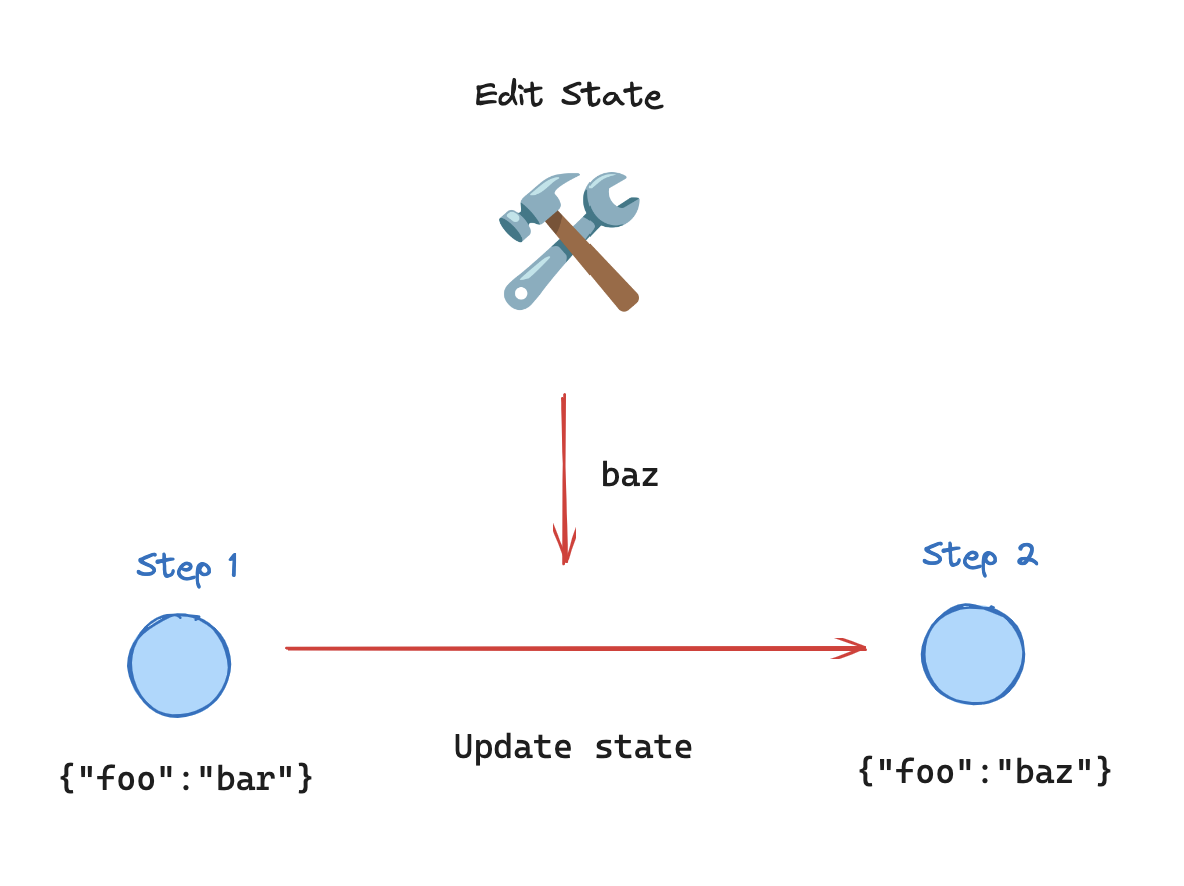

## Setup

First we need to install the packages required

```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core zod
```

Next, we need to set API keys for Anthropic (the LLM we will use)

```bash
export ANTHROPIC_API_KEY=your-api-key
```


Optionally, we can set API key for LangSmith tracing, which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Simple Usage
Let's look at very basic usage of this.

Below, we do two things:

1) We specify the [breakpoint](/langgraphjs/concepts/low_level/#breakpoints) using `interruptBefore` a specified step (node).

2) We set up a [checkpointer](/langgraphjs/concepts/#checkpoints) to save the state of the graph up until this node.

3) We use `.updateState` to update the state of the graph.

In [1]:
import { StateGraph, START, END, Annotation } from "@langchain/langgraph";
import { MemorySaver } from "@langchain/langgraph";

const GraphState = Annotation.Root({
  input: Annotation<string>
});

const step1 = (state: typeof GraphState.State) => {
  console.log("---Step 1---");
  return state;
}

const step2 = (state: typeof GraphState.State) => {
  console.log("---Step 2---");
  return state;
}

const step3 = (state: typeof GraphState.State) => {
  console.log("---Step 3---");
  return state;
}


const builder = new StateGraph(GraphState)
  .addNode("step1", step1)
  .addNode("step2", step2)
  .addNode("step3", step3)
  .addEdge(START, "step1")
  .addEdge("step1", "step2")
  .addEdge("step2", "step3")
  .addEdge("step3", END);


// Set up memory
const graphStateMemory = new MemorySaver()

const graph = builder.compile({
  checkpointer: graphStateMemory,
  interruptBefore: ["step2"]
});

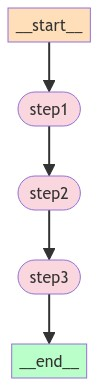

In [2]:
import * as tslab from "tslab";

const drawableGraphGraphState = graph.getGraph();
const graphStateImage = await drawableGraphGraphState.drawMermaidPng();
const graphStateArrayBuffer = await graphStateImage.arrayBuffer();

await tslab.display.png(new Uint8Array(graphStateArrayBuffer));

In [3]:
// Input
const initialInput = { input: "hello world" };

// Thread
const graphStateConfig = { configurable: { thread_id: "1" }, streamMode: "values" as const };

// Run the graph until the first interruption
for await (const event of await graph.stream(initialInput, graphStateConfig)) {
    console.log(`--- ${event.input} ---`);
}

// Will log when the graph is interrupted, after step 2.
console.log("--- GRAPH INTERRUPTED ---");


--- hello world ---
---Step 1---
--- hello world ---
--- GRAPH INTERRUPTED ---


Now, we can just manually update our graph state - 

In [4]:
console.log("Current state!")
const currState = await graph.getState(graphStateConfig);
console.log(currState.values)

await graph.updateState(graphStateConfig, { input: "hello universe!" })

console.log("---\n---\nUpdated state!")
const updatedState = await graph.getState(graphStateConfig);
console.log(updatedState.values)

Current state!
{ input: 'hello world' }
---
---
Updated state!
{ input: 'hello universe!' }


In [5]:
// Continue the graph execution
for await (const event of await graph.stream(null, graphStateConfig)) {
    console.log(`--- ${event.input} ---`);
}

---Step 2---
--- hello universe! ---
---Step 3---
--- hello universe! ---


## Agent

In the context of agents, updating state is useful for things like editing tool calls.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We will use Anthropic's models and a fake tool (just for demo purposes).

In [6]:
// Set up the tool
import { ChatAnthropic } from "@langchain/anthropic";
import { tool } from "@langchain/core/tools";
import { StateGraph, START, END, MessagesAnnotation } from "@langchain/langgraph";
import { MemorySaver } from "@langchain/langgraph";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { AIMessage } from "@langchain/core/messages";
import { z } from "zod";

const search = tool((_) => {
  return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈.";
}, {
  name: "search",
  description: "Call to surf the web.",
  schema: z.string(),
})

const tools = [search]
const toolNode = new ToolNode(tools)

// Set up the model
const model = new ChatAnthropic({ model: "claude-3-5-sonnet-20240620" })
const modelWithTools = model.bindTools(tools)


// Define nodes and conditional edges

// Define the function that determines whether to continue or not
function shouldContinue(state: typeof MessagesAnnotation.State): "action" | typeof END {
  const lastMessage = state.messages[state.messages.length - 1];
  // If there is no function call, then we finish
  if (lastMessage && !(lastMessage as AIMessage).tool_calls?.length) {
      return END;
  }
  // Otherwise if there is, we continue
  return "action";
}

// Define the function that calls the model
async function callModel(state: typeof MessagesAnnotation.State): Promise<Partial<typeof MessagesAnnotation.State>> {
  const messages = state.messages;
  const response = await modelWithTools.invoke(messages);
  // We return an object with a messages property, because this will get added to the existing list
  return { messages: [response] };
}

// Define a new graph
const workflow = new StateGraph(MessagesAnnotation)
  // Define the two nodes we will cycle between
  .addNode("agent", callModel)
  .addNode("action", toolNode)
  // We now add a conditional edge
  .addConditionalEdges(
      // First, we define the start node. We use `agent`.
      // This means these are the edges taken after the `agent` node is called.
      "agent",
      // Next, we pass in the function that will determine which node is called next.
      shouldContinue
  )
  // We now add a normal edge from `action` to `agent`.
  // This means that after `action` is called, `agent` node is called next.
  .addEdge("action", "agent")
  // Set the entrypoint as `agent`
  // This means that this node is the first one called
  .addEdge(START, "agent");

// Setup memory
const memory = new MemorySaver();

// Finally, we compile it!
// This compiles it into a LangChain Runnable,
// meaning you can use it as you would any other runnable
const app = workflow.compile({
  checkpointer: memory,
  interruptBefore: ["action"]
});

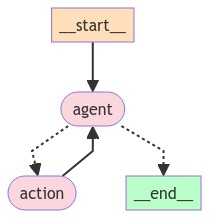

In [7]:
import * as tslab from "tslab";

const drawableGraph = app.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Interacting with the Agent

We can now interact with the agent and see that it stops before calling a tool.


In [8]:
// Thread
const config = { configurable: { thread_id: "3" }, streamMode: "values" as const };

for await (const event of await app.stream({
    messages: [{ role: "human", content: "search for the weather in sf now" }]
}, config)) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
search for the weather in sf now
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Certainly! I can help you search for the current weather in San Francisco. Let me use the search function to find that information for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_0141zTpknasyWkrjTV6eKeT6',
    name: 'search',
    input: { input: 'current weather in San Francisco' }
  }
]


**Edit**

We can now update the state accordingly. Let's modify the tool call to have the query `"current weather in SF"`.

In [9]:
// First, lets get the current state
const currentState = await app.getState(config);

// Let's now get the last message in the state
// This is the one with the tool calls that we want to update
let lastMessage = currentState.values.messages[currentState.values.messages.length - 1]

// Let's now update the args for that tool call
lastMessage.tool_calls[0].args = { query: "current weather in SF" }

// Let's now call `updateState` to pass in this message in the `messages` key
// This will get treated as any other update to the state
// It will get passed to the reducer function for the `messages` key
// That reducer function will use the ID of the message to update it
// It's important that it has the right ID! Otherwise it would get appended
// as a new message
await app.updateState(config, { messages: lastMessage });

{
  configurable: {
    thread_id: '3',
    checkpoint_id: '1ef5e785-4298-6b71-8002-4a6ceca964db'
  }
}


Let's now check the current state of the app to make sure it got updated accordingly

In [10]:
const newState = await app.getState(config);
const updatedStateToolCalls = newState.values.messages[newState.values.messages.length -1 ].tool_calls
console.log(updatedStateToolCalls)

[
  {
    name: 'search',
    args: { query: 'current weather in SF' },
    id: 'toolu_0141zTpknasyWkrjTV6eKeT6',
    type: 'tool_call'
  }
]


**Resume**

We can now call the agent again with no inputs to continue, ie. run the tool as requested. We can see from the logs that it passes in the update args to the tool.

In [11]:
for await (const event of await app.stream(null, config)) {
    console.log(event)
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    if (recentMsg._getType() === "tool") {
        console.log({
            name: recentMsg.name,
            content: recentMsg.content
        })
    } else if (recentMsg._getType() === "ai") {
        console.log(recentMsg.content)
    }
}

{
  messages: [
    HumanMessage {
      "id": "7c69c1f3-914b-4236-b2ca-ef250e72cb7a",
      "content": "search for the weather in sf now",
      "additional_kwargs": {},
      "response_metadata": {}
    },
    AIMessage {
      "id": "msg_0152mx7AweoRWa67HFsfyaif",
      "content": [
        {
          "type": "text",
          "text": "Certainly! I can help you search for the current weather in San Francisco. Let me use the search function to find that information for you."
        },
        {
          "type": "tool_use",
          "id": "toolu_0141zTpknasyWkrjTV6eKeT6",
          "name": "search",
          "input": {
            "input": "current weather in San Francisco"
          }
        }
      ],
      "additional_kwargs": {
        "id": "msg_0152mx7AweoRWa67HFsfyaif",
        "type": "message",
        "role": "assistant",
        "model": "claude-3-5-sonnet-20240620",
        "stop_reason": "tool_use",
        "stop_sequence": null,
        "usage": {
          "input_